# <center> DS572 <center>

##### <center> Group members: Amali Jayatileke, Vidal Mendoza Tinoco, and Kelsey Strachan <center>

---

<span style="color: red;"> **Project Notes/Requirements:** </span>

Choose three out of the five methods (i.e., Logistic Regression, K-Nearest Neighbors, Linear Discriminant Analysis, Decision Trees, and Random Forests) to classify the quality of milk based on its seven features (i.e., pH, Temperature, Taste, Odor, Fat, Turbidity, and Colour). The quality of milk is classified into three grades: low (bad), medium (moderate), and high (good). pH, Temperature, and Colour are quantitative features, and they are given actual values. Taste, Odor, Fat, and Turbidity are qualitative features, and they are assigned 1 (satisfactory) or 0 (unsatisfactory).

<span style="color: red;"> **To accomplish the project, you should perform the following procedures:** </span>
- Data preprocessing: Use appropriate techniques to preprocess data (e.g., normalization, standardization).
- Data resampling: Use appropriate approaches to resample data (e.g., leave-one-out cross- validation, k-fold cross-validation).
- Model building and training: Build three proper models with the three supervised machine learning methods chosen and train them on the dataset.
- Hyperparameter tuning: Tune the respective hyperparameters of the three models to improve their performance.
- Result evaluation and visualization: Evaluate model results with specific metrics (loss and accuracy if applicable), and visualize them in an intuitive way (loss/accuracy vs. epoch graphs if applicable).
- Analysis and discussion: Analyze and discuss the performance of the three models and the strategies you used for performance improvement, as well as the difficulties you encountered and how you solved them.

---

## <ins> Introduction </ins>

Text here if we want to use this file to generate report. Can also use Google Docs or whatever anyone else prefers!

## <ins> Exploratory Data Analysis (EDA) </ins>

Text here if we want to use this file to generate report. Can also use Google Docs or whatever anyone else prefers!

### Dataset description

In [35]:
# Imports packages necessary for data analysis - we can increase/reduce, as needed!
import warnings

import altair as alt
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn import tree
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import RandomizedSearchCV, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    Normalizer,
    OneHotEncoder,
    StandardScaler,
    normalize,
    scale,
    LabelEncoder
)
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Reads in milknew.csv file to perform EDA
full_milk = pd.read_csv("milknew.csv")

In [3]:
# Visualizes first 5 rows. Sets styles for table titles going forward
styles = [
    dict(selector="caption", props=[("font-size", "120%"), ("font-weight", "bold")])
]

full_milk.head().style.set_caption(
    "Table #. First 5 Rows of Full Milk Data"
).set_table_styles(styles)

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
0,6.600000,35,1,0,1,0,254,high
1,6.600000,36,0,1,0,1,253,high
2,8.500000,70,1,1,1,1,246,low
3,9.500000,34,1,1,0,1,255,low
4,6.600000,37,0,0,0,0,255,medium


In [4]:
# Renaming temperature column due to typographical error
full_milk = full_milk.rename(columns={"Temprature": "Temperature", "Fat ":"Fat"})

In [5]:
# Visualizes first 5 rows. Sets styles for table titles going forward
styles = [
    dict(selector="caption", props=[("font-size", "120%"), ("font-weight", "bold")])
]

full_milk.head().style.set_caption(
    "Table #. Updated Full Milk Data"
).set_table_styles(styles)

,pH,Temperature,Taste,Odor,Fat,Turbidity,Colour,Grade
0,6.600000,35,1,0,1,0,254,high
1,6.600000,36,0,1,0,1,253,high
2,8.500000,70,1,1,1,1,246,low
3,9.500000,34,1,1,0,1,255,low
4,6.600000,37,0,0,0,0,255,medium


Each columns' `dtype` is observed by calling `.info()` on the `full_milk` dataframe. Null values noted will be addressed and filled with `missing`, `median`, or `most_frequent` using `SimpleImputer()` strategy.

In [6]:
# Calls info on full_milk data
milk_info = full_milk.info()
milk_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pH           1059 non-null   float64
 1   Temperature  1059 non-null   int64  
 2   Taste        1059 non-null   int64  
 3   Odor         1059 non-null   int64  
 4   Fat          1059 non-null   int64  
 5   Turbidity    1059 non-null   int64  
 6   Colour       1059 non-null   int64  
 7   Grade        1059 non-null   object 
dtypes: float64(1), int64(6), object(1)
memory usage: 66.3+ KB


In [7]:
# Calls describe on full_milk data
milk_stats = (
    full_milk.describe(include="all")
    .style.set_caption("Table #. Statistics of Full Milk Data")
    .set_table_styles(styles)
)
milk_stats

,pH,Temperature,Taste,Odor,Fat,Turbidity,Colour,Grade
count,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059
unique,nan,nan,nan,nan,nan,nan,nan,3
top,nan,nan,nan,nan,nan,nan,nan,low
freq,nan,nan,nan,nan,nan,nan,nan,429
mean,6.630123,44.226629,0.546742,0.432483,0.671388,0.491029,251.840415,nan
std,1.399679,10.098364,0.498046,0.495655,0.469930,0.500156,4.307424,nan
min,3.000000,34.000000,0.000000,0.000000,0.000000,0.000000,240.000000,nan
25%,6.500000,38.000000,0.000000,0.000000,0.000000,0.000000,250.000000,nan
50%,6.700000,41.000000,1.000000,0.000000,1.000000,0.000000,255.000000,nan
75%,6.800000,45.000000,1.000000,1.000000,1.000000,1.000000,255.000000,nan


---

<span style="color: red;"> **Further EDA to follow :)** </span>

## <ins> Methods & Results </ins>

In [8]:
# Splits data into train and test sets
train_df, test_df = train_test_split(full_milk, test_size=0.2, random_state=2025)

`train_df` and `test_df` are further separated into feature and target train and test sets. The first five rows of `X_train` are called to assess data.

In [9]:
# Splits data into train and test sets
X_train = train_df.drop(columns=["Grade"])
y_train = train_df["Grade"]
X_test = test_df.drop(columns=["Grade"])
y_test = test_df["Grade"]

X_train.head().style.set_caption(
    "Table #. First 5 Rows of Feature Training Data"
).set_table_styles(styles)

,pH,Temperature,Taste,Odor,Fat,Turbidity,Colour
884,9.000000,43,1,0,1,1,250
715,3.000000,40,1,1,1,1,255
450,4.500000,38,0,1,1,1,255
856,6.800000,40,1,1,1,1,255
667,6.600000,37,1,1,1,1,255


In [10]:
print("Training set shape of X_train and y_train:", X_train.shape, y_train.shape)

Training set shape of X_train and y_train: (847, 7) (847,)


In [11]:
# Checks the distribution of positive and negative target values in y_train for class imbalance
check_target_count = y_train.value_counts(normalize=True)
check_target_count

Grade
low       0.414404
medium    0.364817
high      0.220779
Name: proportion, dtype: float64

`.dtypes` is called on the training set to assess data type of each feature column prior to preprocessing.

In [12]:
# Calls .dtypes of of X_train
X_train.dtypes

pH             float64
Temperature      int64
Taste            int64
Odor             int64
Fat              int64
Turbidity        int64
Colour           int64
dtype: object

In [13]:
X_train.columns

Index(['pH', 'Temperature', 'Taste', 'Odor', 'Fat', 'Turbidity', 'Colour'], dtype='object')

In [14]:
# Separates columns used for feature table into numeric, categorical, and binary features
numeric_features = ["pH",
                   "Temperature",
                   "Colour"]
categorical_features = [
    "Taste",
    "Odor",
    "Fat",
    "Turbidity"
]
#binary_features = [""]

The `numeric_transformer` contains `SimpleImputer()` with strategy `median` alongside `StandardScaler()`. These are used to impute missing feature values with the median and to scale the data of the numeric feature, respectively.

The `categorical_transformer` contains `SimpleImputer()` with strategy `constant` to impute empty cells with the value `missing`. `OneHotEncoder()` is also used to transform the categorical features into a numeric array of `dtype` integer. `handle_unknown="ignore"` is specified to encode zeroes if an unknown category is found.

The `binary_transformer` contains `SimpleImputer()` with strategy `most_frequent` to impute with the most frequent label if found empty. `OneHotEncoder()` is used again, however, with `drop="if_binary"` argument to drop the first category in a feature that contains two categories.

In [15]:
# Creates numeric, categorical, and binary pipelines for data preprocessing
numeric_transformer = make_pipeline(StandardScaler())

categorical_transformer = make_pipeline(
    OneHotEncoder(dtype=int, handle_unknown="ignore"),
)
#binary_transformer = make_pipeline(
 #   SimpleImputer(strategy="most_frequent"),
  #  OneHotEncoder(drop="if_binary", dtype=int),
#)

`make_column_transformer` is used to compile all pipelines defined above into a single column transformer called `preprocessor`

In [16]:
# Generates column transformer that contains all necessary pipelines
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features),
    remainder="passthrough",
)

Before assessing estimators, a loop is generated to determine the optimal strategy for the baseline model.

In [17]:
# For loop code that determines best strategy to use in baseline model
strategies = ["stratified", "most_frequent", "uniform"]
accuracy_list = list()

for selection in strategies:
    model = DummyClassifier(strategy=selection, random_state=2025)
    model.fit(X_train, y_train)
    accuracy_list.append(round(model.score(X_train, y_train), 2))

dc_accuracies = {"strategy": strategies, "accuracy": accuracy_list}
dc_accuracies

{'strategy': ['stratified', 'most_frequent', 'uniform'],
 'accuracy': [0.37, 0.41, 0.33]}

In [18]:
# Creates baseline model and cross validates with X_train and y_train data. Returns the mean times and mean scores.
dummy_model = DummyClassifier(strategy="most_frequent", random_state=2023)
dummy_scores = pd.DataFrame(
    cross_validate(dummy_model, X_train, y_train, cv=5, return_train_score=True)
)
mean_dummy_scores = dummy_scores.mean()
mean_dummy_scores

fit_time       0.001415
score_time     0.000838
test_score     0.414403
train_score    0.414404
dtype: float64

Evaluation metrics are established below that will be used in models moving forward. Scoring types `accuracy`, `precision`, `recall` and `f1` will be evaluated.

In code that follows, `make_pipeline` is used to generate multiple different pipelines containing column transformer `preprocessor` and various estimators. `DecisionTreeClassifier()` is first estimator examined for test and train scores followed by `KNeighborsClassifier()`, and `LogisticRegression()`.

In [40]:
scoring = ['accuracy','precision', 'recall', 'f1']

In [41]:
# Pipeline creates DecisionTreeClassifier and cross validates with X_train and y_train data. Returns scoring.
dt_milk_pipe = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=2025))

dt_milk = pd.DataFrame(
    cross_validate(
        dt_milk_pipe, X_train, y_train, cv=10, return_train_score=True, scoring=scoring
    )
)

dt_milk.style.set_caption(
    "Table #. Scores from DecisionTreeClassifier"
).set_table_styles(styles)

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,0.012724,0.007366,1.000000,1.000000,nan,nan,nan,nan,nan,nan
1,0.005600,0.005381,0.988235,1.000000,nan,nan,nan,nan,nan,nan
2,0.005363,0.005277,1.000000,1.000000,nan,nan,nan,nan,nan,nan
3,0.004458,0.003770,1.000000,1.000000,nan,nan,nan,nan,nan,nan
4,0.003717,0.003559,1.000000,1.000000,nan,nan,nan,nan,nan,nan
5,0.003921,0.003867,1.000000,1.000000,nan,nan,nan,nan,nan,nan
6,0.003933,0.003425,1.000000,1.000000,nan,nan,nan,nan,nan,nan
7,0.003754,0.003496,1.000000,1.000000,nan,nan,nan,nan,nan,nan
8,0.003794,0.003561,1.000000,1.000000,nan,nan,nan,nan,nan,nan
9,0.003457,0.003316,0.988095,1.000000,nan,nan,nan,nan,nan,nan


In [20]:
# Returns mean fit times and mean accuracy, precision, recall and f1 scores
dt_mean = dt_milk.mean()
dt_mean

fit_time       0.005679
score_time     0.002479
test_score     0.997633
train_score    1.000000
dtype: float64

In [21]:
# Pipeline creates KNeighborsClassifer and cross validates with X_train and y_train. Returns scoring.
knn_milk_pipe = make_pipeline(preprocessor, KNeighborsClassifier())
knn_milk = pd.DataFrame(
    cross_validate(
        knn_milk_pipe, X_train, y_train, cv=10, return_train_score=True, scoring='accuracy'
    )
)
knn_milk.style.set_caption(
    "Table #. Scores from KNeighborsClassifier"
).set_table_styles(styles)

,fit_time,score_time,test_score,train_score
0,0.026491,0.006599,0.988235,0.996063
1,0.004718,0.004542,0.988235,0.996063
2,0.003666,0.003756,0.976471,0.992126
3,0.003589,0.003825,1.000000,0.994751
4,0.003268,0.003404,1.000000,0.994751
5,0.003559,0.003611,1.000000,0.994751
6,0.003209,0.003409,1.000000,0.994751
7,0.003052,0.003412,0.988095,0.996068
8,0.003203,0.003368,1.000000,0.994758
9,0.003418,0.003508,0.988095,0.996068


In [22]:
# Returns mean fit times and mean accuracy, precision, recall and f1 scores
knn_mean = knn_milk.mean()
knn_mean

fit_time       0.005817
score_time     0.003943
test_score     0.992913
train_score    0.995015
dtype: float64

In [23]:
# Pipeline creates unbalanced LogisticRegression and cross validates with X_train and y_train. Returns scoring.
lr_milk_pipe = make_pipeline(preprocessor, LogisticRegression(random_state=2025))
lr_milk = pd.DataFrame(
    cross_validate(
        lr_milk_pipe, X_train, y_train, cv=10, return_train_score=True, scoring='accuracy'
    )
)
lr_milk.style.set_caption("Table #. Scores from LogisticRegression").set_table_styles(
    styles
)

,fit_time,score_time,test_score,train_score
0,0.023487,0.003009,0.823529,0.847769
1,0.009346,0.002735,0.811765,0.853018
2,0.009256,0.002993,0.823529,0.847769
3,0.008461,0.002236,0.811765,0.853018
4,0.007222,0.002004,0.835294,0.850394
5,0.006755,0.001892,0.917647,0.837270
6,0.007083,0.001919,0.858824,0.843832
7,0.006351,0.001809,0.833333,0.846658
8,0.006785,0.001923,0.892857,0.844037
9,0.006633,0.002225,0.857143,0.844037


In [24]:
# Returns mean fit times and mean accuracy, precision, recall and f1 scores
lr_mean = lr_milk.mean()
lr_mean

fit_time       0.009138
score_time     0.002275
test_score     0.846569
train_score    0.846780
dtype: float64

Incorporation of`class_weight="balanced"` into`LogisticRegression` model will handle the slight class imbalance previously noted.

In [25]:
# Pipeline creates balanced LogisticRegression and cross validates with X_train and y_train. Returns mean scoring.
balanced_lr_milk_pipe = make_pipeline(
    preprocessor, LogisticRegression(class_weight="balanced", random_state=2025)
)
balanced_milk = pd.DataFrame(
    cross_validate(
        balanced_lr_milk_pipe,
        X_train,
        y_train,
        return_train_score=True,
        scoring='accuracy',
    )
)
balanced_mean = balanced_milk.mean()
balanced_mean

fit_time       0.010003
score_time     0.002599
test_score     0.840675
train_score    0.843573
dtype: float64

#### **Need to fix hyperparameters below:**

In [26]:
# Tunes LogisticRegression hyperparameters max_iter, C, and penalty

param_grid = {
    "logisticregression__max_iter": np.arange(1000, 5000, 100),
    "logisticregression__C": np.arange(1, 100, 1),
    "logisticregression__penalty": ["l2", "none"],
}

lr_milk_search = RandomizedSearchCV(
    balanced_lr_milk_pipe,
    param_grid,
    cv=5,
    return_train_score=True,
    n_jobs=-1,
    n_iter=50,
    scoring="accuracy",
    random_state=2025,
)
lr_milk_search.fit(X_train, y_train)
best_params = lr_milk_search.best_params_
best_lr_score = lr_milk_search.best_score_
print("Best parameters:", best_params)
print("Best score:", best_lr_score)

Best parameters: {'logisticregression__penalty': 'l2', 'logisticregression__max_iter': 4900, 'logisticregression__C': 84}
Best score: 0.8371249564914723


/opt/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
125 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
42 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 660, in fit
    self._final_est

In [27]:
# Accesses mean test scores from C hyperparameter tuning. Compiles into dataframe and sorts scores in descending order
search_results = pd.DataFrame(lr_milk_search.cv_results_)[
    ["mean_test_score", "param_logisticregression__C"]
]
search_results = (
    search_results.sort_values(by="mean_test_score", ascending=False).head()
    .style.set_caption(
        "Table #. Mean Test Scores Associated with C Hyperparameter in Descending Order"
    )
    .set_table_styles(styles)
)
search_results

,mean_test_score,param_logisticregression__C
0,0.837125,84
10,0.837125,45
28,0.837125,83
25,0.837125,55
39,0.837125,40


`best_model` establishes the `.best_estimator_` in order to access Logistic Regression coefficients for interpretation.

In [29]:
# Shows best estimator
best_model = lr_milk_search.best_estimator_
best_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['pH', 'Temperature',
                                                   'Colour']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(dtype=<class 'int'>,
                                                                                 handle_unknown='ignore'))]),
                                                  ['Taste', 'Odor', 'Fat',
                                                   'Turbidity'])])),
                ('logisticregression',
                 LogisticRegression(C=84, class_weight='balanced',
                                    max_iter=4900, random_state=2025))])

In [42]:
# Compares true against predicted target labels and associates with probability to predict 
predict_y = lr_milk_search.predict(X_train)
y_proba = lr_milk_search.predict_proba(X_train)
milk_targets = pd.DataFrame(
    {
        "y": y_train,
        "pred_y": predict_y.tolist(),
        "probability grade": y_proba[:, 0].tolist(),
    }
).sort_values(by="probability grade", ascending=False)
milk_targets.head().style.set_caption(
    "Table #. True vs. Predicated Targets and their Probabilities"
).set_table_styles(styles)

,y,pred_y,probability grade
603,high,high,0.992699
105,high,high,0.992699
425,high,high,0.992699
736,high,high,0.992699
161,high,high,0.992699


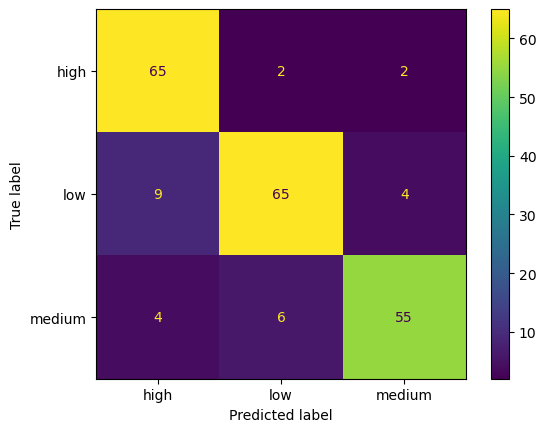

In [36]:
# Plots confusion matrix of estimator using test data
milk_confusion_plot = ConfusionMatrixDisplay.from_estimator(lr_milk_search,X_test,y_test)
milk_confusion_plot

In [37]:
# Prints classification report of tested and predicted target data
y_pred = lr_milk_search.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        high       0.83      0.94      0.88        69
         low       0.89      0.83      0.86        78
      medium       0.90      0.85      0.87        65

    accuracy                           0.87       212
   macro avg       0.88      0.87      0.87       212
weighted avg       0.88      0.87      0.87       212



Evaluating the `training_score` of the best scoring model.

In [38]:
# Scores X_train and y_train data using tuned Logistic Regression model
training_score = lr_milk_search.score(X_train, y_train)
training_score

0.8512396694214877

Evaluating the `testing_score` of the best scoring model.

In [39]:
# Scores X_test and y_test data using tuned Logistic Regression model
test_score = lr_milk_search.score(X_test, y_test)
test_score

0.8726415094339622

## <ins> Discussion </ins>

Text here if we want to use this file to generate report. Can also use Google Docs or whatever anyone else prefers!

## <ins> Conclusion </ins>

Text here if we want to use this file to generate report. Can also use Google Docs or whatever anyone else prefers!

## <ins> References </ins>

1. [Milk Data](https://www.kaggle.com/datasets/cpluzshrijayan/milkquality/data)